# Тинькофф квест

Перед нами данные проекта Тинькофф квест. Построим воронку, которая показывает в динамике по неделям и месяцам, сколько клиентов посещает сайт, и какая доля из них регистрируется на нем \ подает заявку на игру \ по факту приходит на нее. Количество клиентов и конверсии изобразим на одном графике.

In [ ]:
!pip3 install psycopg2-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import psycopg2
from sqlalchemy import create_engine

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import plotly.express as px
from plotly import graph_objects as go
import time
from plotly.subplots import make_subplots

sns.set_style("darkgrid")

# Подключаемся к базе и выгружаем данные

In [ ]:
conn = psycopg2.connect(
    host=" ",
    port=5432,
    database="postgres",
    user=" ",
    password=" ",
)
cur = conn.cursor()

In [ ]:
def select(sql):
  return pd.read_sql(sql, conn)

In [ ]:
sql = '''
            SELECT * 
            FROM msu_analytics.game
            LIMIT 5
        '''

In [ ]:
select(sql)

/usr/local/lib/python3.9/dist-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,game_rk,quest_rk,employee_rk,game_dttm,price,game_flg,finish_flg,time
0,22,2,14,2022-12-14 12:04:00.773186,2461.88,1,1,20:34:46
1,54,22,1,2022-10-25 20:09:48.591832,2093.63,1,0,22:20:10
2,70,14,10,2023-01-21 17:53:24.643384,1955.76,1,1,20:44:50
3,102,25,5,2022-11-21 03:42:13.494004,1156.75,1,1,16:45:18
4,150,29,13,2022-12-29 16:17:59.851944,1579.96,1,0,07:18:03


Сформируем общий запрос и посомтрим сколько в нем строчек 

In [ ]:
sql = '''
      SELECT COUNT(c.client_rk)
      FROM msu_analytics.client AS c 
      left join msu_analytics.account AS a on c.client_rk = a.client_rk 
      left join msu_analytics.application AS ap on ap.account_rk = a.account_rk 
      left join msu_analytics.game AS g on g.game_rk = ap.game_rk 
        '''
select(sql)

/usr/local/lib/python3.9/dist-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,count
0,4315


Объём данных не большой, можем выгрузить и уже работать в pandas 

In [ ]:
sql = '''
      SELECT c.client_rk, c.visit_dttm, a.registration_dttm, ap.application_dttm, g.game_flg
      FROM msu_analytics.client AS c 
      left join msu_analytics.account AS a on c.client_rk = a.client_rk 
      left join msu_analytics.application AS ap on ap.account_rk = a.account_rk 
      left join msu_analytics.game AS g on g.game_rk = ap.game_rk
        '''
select(sql)

/usr/local/lib/python3.9/dist-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,client_rk,visit_dttm,registration_dttm,application_dttm,game_flg
0,478,2022-09-18 09:02:15.622278,2022-09-19 04:06:48.824524,NaT,NaN
1,591,2022-09-06 13:12:56.542908,2022-09-06 22:24:45.361836,NaT,NaN
2,772,2023-01-15 00:44:04.570005,2023-01-15 18:30:13.206379,NaT,NaN
3,41,2022-12-07 15:13:13.343434,NaT,NaT,NaN
4,57,2022-11-30 12:03:46.625687,NaT,NaT,NaN
...,...,...,...,...,...
4310,3989,2023-01-18 07:33:37.167199,NaT,NaT,NaN
4311,4005,2022-09-20 13:20:56.457826,NaT,NaT,NaN
4312,4021,2023-01-06 17:04:05.888078,NaT,NaT,NaN
4313,4053,2022-09-23 18:49:47.155232,NaT,NaT,NaN


# Загрузим данные и изучим общую информацию.

In [ ]:
data = pd.io.sql.read_sql(sql, conn)

/usr/local/lib/python3.9/dist-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [ ]:
!gdown 1ofLb94JVcOJBgg9883PplZjYMqa41zvF

Downloading...
From: https://drive.google.com/uc?id=1ofLb94JVcOJBgg9883PplZjYMqa41zvF
To: /content/tinkoff_quest.csv
100% 197k/197k [00:00<00:00, 75.3MB/s]


In [ ]:
data = pd.read_csv('/content/tinkoff_quest.csv', parse_dates=['visit_dttm', 'registration_dttm','application_dttm'])

In [ ]:
data.head(5)

,client_rk,visit_dttm,registration_dttm,application_dttm,game_flg
0,1538,2022-11-30 02:48:14.694552,2022-11-30 05:53:48.646512,NaT,NaN
1,1682,2022-12-27 15:01:37.969454,2022-12-27 15:16:44.395558,NaT,NaN
2,2833,2022-10-11 01:42:08.434754,2022-10-11 04:23:59.255146,NaT,NaN
3,20,2022-12-17 19:12:33.927380,NaT,NaT,NaN
4,36,2022-09-30 22:58:27.223248,NaT,NaT,NaN


In [ ]:
data.columns

Index(['client_rk', 'visit_dttm', 'registration_dttm', 'application_dttm',
       'game_flg'],
      dtype='object')

In [ ]:
data = data.rename(columns={'client_rk':'id', 'visit_dttm': 'site_visit', 'registration_dttm': 'registration', 'application_dttm' : 'application_game', 'game_flg':'game' })    # переименование столбцов

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4315 entries, 0 to 4314
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                4315 non-null   int64         
 1   site_visit        4315 non-null   datetime64[ns]
 2   registration      1243 non-null   datetime64[ns]
 3   application_game  512 non-null    datetime64[ns]
 4   game              512 non-null    float64       
dtypes: datetime64[ns](3), float64(1), int64(1)
memory usage: 168.7 KB


In [ ]:
print(f"МИнимальная дата: {data['site_visit'].min()}, максиамальная дата: {data['site_visit'].max()}")

МИнимальная дата: 2022-09-01 03:32:43.977277, максиамальная дата: 2023-02-02 02:22:04.176738


У нас есть данные с 01-09-2022 по 02-02-2023, чтобы не запутаться при излвлечени месяца будем указывать еще год.

In [ ]:
data.head(2)

,id,site_visit,registration,application_game,game
0,1538,2022-11-30 02:48:14.694552,2022-11-30 05:53:48.646512,NaT,NaN
1,1682,2022-12-27 15:01:37.969454,2022-12-27 15:16:44.395558,NaT,NaN


В ТЗ не указана, какая именно конверсия интересует заказчика, тк возможности уточнить в данный момент нет, будем строить отношение количества посетителей на определённом шаге к количеству посетителей на первом шаге. Чтобы конверсия получилась объективной, за количество посетителей будем брать количество уникальных ID на дату посещения. 

In [ ]:
df = data.groupby(['id']).agg({
                'site_visit' : 'first',
                'registration': 'first',
                'application_game': 'count',
                'game': 'sum'
                }).reset_index()

In [ ]:
df.head()

,id,site_visit,registration,application_game,game
0,1,2022-09-27 04:47:55.218228,NaT,0,0.0
1,2,2022-10-22 05:01:43.032205,NaT,0,0.0
2,3,2022-09-25 21:18:23.734588,2022-09-26 04:34:12.392193,0,0.0
3,4,2022-11-30 04:44:11.949916,2022-12-01 00:58:56.483252,2,2.0
4,5,2023-01-01 11:06:52.996647,NaT,0,0.0


In [ ]:
df['week'] = df['site_visit'].dt.isocalendar().week
df['month'] = pd.to_datetime(df['site_visit']).dt.to_period("M")
df['week_month'] = df['site_visit'].dt.strftime('%m мес. - %W нед.')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4096 entries, 0 to 4095
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                4096 non-null   int64         
 1   site_visit        4096 non-null   datetime64[ns]
 2   registration      1024 non-null   datetime64[ns]
 3   application_game  4096 non-null   int64         
 4   game              4096 non-null   float64       
 5   week              4096 non-null   UInt32        
 6   month             4096 non-null   period[M]     
 7   week_month        4096 non-null   object        
dtypes: UInt32(1), datetime64[ns](2), float64(1), int64(2), object(1), period[M](1)
memory usage: 244.1+ KB


In [ ]:
(df.isna().agg(['sum', 'mean'])
    .style.set_caption('Количество пропусков')
    .set_table_styles([{'selector': 'caption', 
                     'props': [('color', 'black'), ('font-size', '15px')]
                     }]))

,id,site_visit,registration,application_game,game,week,month,week_month
sum,0.000000,0.000000,3072.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mean,0.000000,0.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
df['site_visit'] =  df['site_visit'].dt.date
df['registration'] = df['registration'].dt.date

In [ ]:
print('Количество уникальных значений в каждой колонке:')
for index in df.columns:
    row = df[index].nunique()
    print(f'Уникальный значений {index}: {row}')

Количество уникальных значений в каждой колонке:
Уникальный значений id: 4096
Уникальный значений site_visit: 155
Уникальный значений registration: 154
Уникальный значений application_game: 5
Уникальный значений game: 4
Уникальный значений week: 23
Уникальный значений month: 6
Уникальный значений week_month: 28


**Описание данных**

`id` - ID клиента  
`site_visit` - Дата и время, когда клиент крайний раз посещал
сайт  
`registration` - Дата и время регистрации клиента на сайте  
`application_game` - Дата и время заявки на игру клиента  
`game` - Флаг того, что игра состоялась  
`week` - Номер недели, когда клиент крайний раз посещал
сайт       
`month`- год и месяц, когда клиент крайний раз посещал
сайт     

In [ ]:
df.head()

,id,site_visit,registration,application_game,game,week,month,week_month
0,1,2022-09-27,NaT,0,0.0,39,2022-09,09 мес. - 39 нед.
1,2,2022-10-22,NaT,0,0.0,42,2022-10,10 мес. - 42 нед.
2,3,2022-09-25,2022-09-26,0,0.0,38,2022-09,09 мес. - 38 нед.
3,4,2022-11-30,2022-12-01,2,2.0,48,2022-11,11 мес. - 48 нед.
4,5,2023-01-01,NaT,0,0.0,52,2023-01,01 мес. - 00 нед.


# Строим график конверсии

## Сформируем таблицы.  

Недели

In [ ]:
pivot_week = df.groupby('week').agg({
                'id' : 'nunique',
                'registration': 'count',
                'application_game': 'sum',
                'game': 'sum'
                }).reset_index()
                
pivot_week.head(3) 

,week,id,registration,application_game,game
0,1,201,58,27,4.0
1,2,205,47,23,6.0
2,3,181,43,21,5.0


In [ ]:
pivot_week = pivot_week.reindex(index= [int(item) for item in range(5, 23)] + [0, 1, 2, 3, 4])
pivot_week['week'] = pivot_week['week'].astype(str)

In [ ]:
pivot_week.head(3)

,week,id,registration,application_game,game
5,35,111,32,15,8.0
6,36,184,31,9,6.0
7,37,167,43,27,11.0


In [ ]:
pivot_week['percent_registrations'] = np.round(pivot_week['registration'] / pivot_week['id'] * 100, 2)
pivot_week['percent_application'] = np.round(pivot_week['application_game'] / pivot_week['id'] * 100, 2)
pivot_week['percent_game'] = np.round(pivot_week['game'] / pivot_week['id'] * 100, 2)

In [ ]:
pivot_week_percent = pivot_week.melt(
    id_vars=['week', 'id'], value_vars=['percent_registrations', 'percent_application', 'percent_game'])
pivot_week_percent = pivot_week_percent.replace({'variable':{'percent_registrations': '% зарегистрировались', 'percent_application':'% подали заявку', 'percent_game':'% пришли на игру'}})

Месяцы

In [ ]:
pivot_month = df.groupby('month').agg({
                'id' : 'nunique',
                'registration': 'count',
                'application_game': 'sum',
                'game': 'sum'
                }).reset_index()
pivot_month

,month,id,registration,application_game,game
0,2022-09,778,190,91,59.0
1,2022-10,843,217,109,74.0
2,2022-11,786,200,101,71.0
3,2022-12,805,196,100,39.0
4,2023-01,852,213,111,21.0
5,2023-02,32,8,0,0.0


In [ ]:
pivot_month['percent_registrations'] = np.round(pivot_month['registration'] / pivot_month['id'] * 100, 2)
pivot_month['percent_application'] = np.round(pivot_month['application_game'] / pivot_month['id'] * 100, 2)
pivot_month['percent_game'] = np.round(pivot_month['game'] / pivot_month['id'] * 100, 2)
pivot_month['month'] = pivot_month['month'].astype(str)

## Строим графики

In [ ]:
fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(
    go.Scatter(x=pivot_month['month'], y=pivot_month['percent_registrations'], mode='lines', name='% зарегистрировались'),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=pivot_month['month'], y=pivot_month['percent_application'], mode='lines', name='% подали заявку',),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=pivot_month['month'], y=pivot_month['percent_game'], mode='lines', name='% пришли на игру',),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=pivot_month['month'], y=pivot_month['id'], mode='lines',  line=dict(color='rgb(255, 215, 0)', width=3), name='посетили сайт'),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    autosize=False,
    width=1700, 
    height=550,
    title_text="<b>Воронка по месяцам</b>",
    title_x=0.4,
    plot_bgcolor = 'rgb(235,235,235)'
)

fig.update_layout(margin=dict(l=20, r=0, t=45, b=0))

# Set x-axis title
fig.update_xaxes(title_text="<b>дата</b>")

# Set y-axes titles
fig.update_yaxes(title_text="<b>конверсия</b> к количеству посетителей", secondary_y=False, range=(0, 40), constrain='domain')
fig.update_yaxes(title_text="<b>кколичество посетителейк</b>", color='rgb(238, 197, 0)', secondary_y=True, range=(0, 860), constrain='domain')

 
fig.show()

В феврале есть данные за первые два дня, этот месяц мы не будем учитывать в анализе.  
За исключением пришедших на игру, все метрики на ведут себя стабильно. Надо посмотреть понедельный график, возможно он точнее отразит ситуацию.

In [ ]:
fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(
    go.Scatter(x=pivot_week['week'], y=pivot_week['percent_registrations'], mode='lines', name='% зарегистрировались'),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=pivot_week['week'], y=pivot_week['percent_application'], mode='lines', name='% подали заявку',),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=pivot_week['week'], y=pivot_week['percent_game'], mode='lines', name='% пришли на игру',),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=pivot_week['week'], y=pivot_week['id'], mode='lines',  line=dict(color='rgb(255, 215, 0)', width=3), name='посетили сайт'),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    autosize=False,
    width=1700, 
    height=550,
    title_text="<b>Воронка по неделям</b>",
    title_x=0.4,
    plot_bgcolor = 'rgb(235,235,235)'
)

fig.update_layout(margin=dict(l=20, r=0, t=45, b=0))

# Set x-axis title
fig.update_xaxes(title_text="<b>номер недели</b>")

# Set y-axes titles
fig.update_yaxes(title_text="<b>конверсия</b> к количеству посетителей", secondary_y=False, range=(0, 45), constrain='domain')
fig.update_yaxes(title_text="количество посетителей", secondary_y=True, range=(0, 210), constrain='domain')

 
fig.show()

На недельном графике видно, что спад пришедших на игру начинается с 47 недели, при это показатели других метрик не изменились.  
Так же заметен резкий провал на 46 неделе, клиенты заходили, далее регистрировались на сайте, но подали в два раза меньше заявок на игру и меньше состоялось игр.

Иногда бывают сложности с отображением Ploty, добавим график построенный библиотекой seaborn

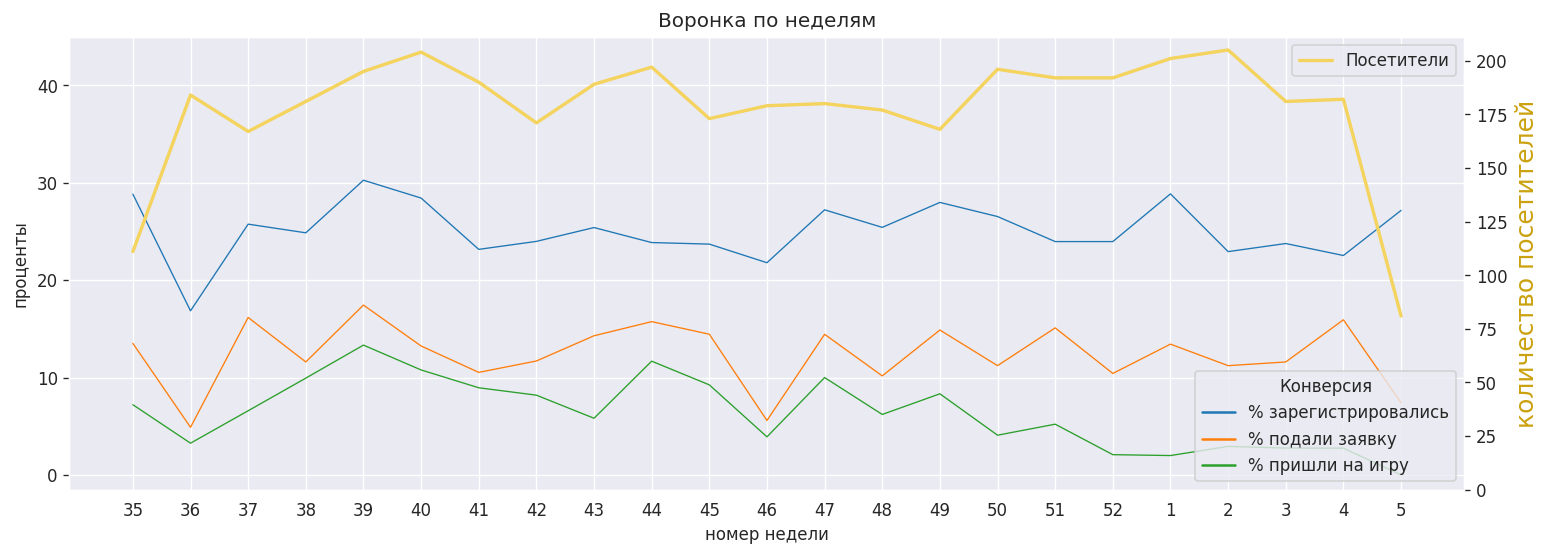

In [ ]:
'''Раз построил, оставлю здесь'''
f, ax = plt.subplots(figsize=(15, 5), dpi= 120)

sns.lineplot(data=pivot_week_percent, x="week", y= 'value', hue='variable',  lw = 0.8, ax=ax)

ax.set_ylim(ymax=45)
ax.set_title('Воронка по неделям')
ax.set_xlabel('номер недели')
ax.set_ylabel('проценты')
ax.legend(loc ='lower right', title='Конверсия', title_fontsize= 10)

ax2 = ax.twinx()

sns.lineplot(data=pivot_week_percent, x="week", y= 'id', color='#F4D35E', lw = 2, ax=ax2, label='Посетители')

ax2.grid(None)
ax2.set_ylim(ymin=0)
ax2.set_ylabel('количество посетителей',  color ='#cba10e', fontsize=15)
ax2.legend()

plt.show()

#Вывод:

В ходе исследования нами выявлено, что начиная с 47 недели упала конверсия клиентов посетивших игру. При это количество посетителей, регистрация и заявок на игру не изменилось. Так же заметен резкий спад заявок и игр на 46 неделе.  
Рекомендуем проанализировать изменения, которые были в ноябре 2022 года.
